<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

Import libraries

In [10]:
import matplotlib.pyplot as plt
import keras_tuner as kt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_sample_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from keras_tuner import Objective
from keras import backend as K
from optuna.integration import TFKerasPruningCallback
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Read pre-processed data "all_encoded_df"

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1-9Tp6ZMZG9zKieBTO_Sd6W-HdzXPy5OL'
file_name = 'selected_features_500.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_df = pd.read_csv(file_name)
selected_features_df.shape

^C
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'pydrive'

In [2]:
selected_features_df = pd.read_csv('selected_features_80.csv')

In [3]:
selected_features_df['uti'] = selected_features_df['uti'].replace({True: 1, False: 0})
selected_features_df = selected_features_df.astype(int)

In [11]:
selected_features_df.head()
selected_features_df.shape

(58976, 81)

In [12]:
selected_features_df['uti'].value_counts()

uti
0    52421
1     6555
Name: count, dtype: int64

train test split

In [64]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [20]:
# smote = SMOTE(random_state=42)

# # Fit and resample using SMOTE on the training data
# X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [65]:
X_test.shape

(11796, 80)

In [66]:
from sklearn.preprocessing import StandardScaler

# Scale data
StdScaler = StandardScaler()

# X_train_scaled = StdScaler.fit_transform(X_train_sm)
X_train_scaled = StdScaler.fit_transform(X_train)
X_val_scaled = StdScaler.transform(X_val)
X_test_scaled = StdScaler.transform(X_test)

train val split

### DNN (Leon)

In [78]:
from sklearn.metrics import f1_score

# Define the balanced accuracy metric
def balanced_accuracy(y_true, y_pred):
    y_pred_labels = K.round(y_pred)
    recall_pos = K.sum(K.round(K.clip(y_true * y_pred_labels, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    recall_neg = K.sum(K.round(K.clip((1-y_true) * (1-y_pred_labels), 0, 1))) / (K.sum(K.round(K.clip(1-y_true, 0, 1))) + K.epsilon())
    balanced_acc = (recall_pos + recall_neg) / 2.0
    return balanced_acc

def balanced_f1(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    balanced_f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return balanced_f1

# function that plots the 
def plot_history(history, title):
    plt.figure(figsize=(12, 12))  # se

    plt.subplot(4, 2, 1) 
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")  # xlabel
    plt.grid(True)
    plt.title('Training & Validation Loss per Epoch')
    plt.legend()
    
    plt.subplot(4, 2, 2)
    plt.plot(history.history['balanced_f1'], label='Train Balanced F1')
    plt.plot(history.history['val_balanced_f1'], label='Val Balanced F1')
    plt.title('Training & Validation F1 per Epoch')
    plt.xlabel("Epoch")  # xlabel
    plt.grid(True)
    plt.legend() 

    # plt.subplot(4, 2, 2)
    # plt.plot(history.history['balanced_accuracy'], label='Train Balanced Accuracy')
    # plt.plot(history.history['val_balanced_accuracy'], label='Val Balanced Accuracy')
    # plt.title('Training & Validation Accuracy per Epoch')
    # plt.xlabel("Epoch")  # xlabel
    # plt.grid(True)
    # plt.legend() 
    
    plt.suptitle(title, fontweight='bold')
    plt.tight_layout() 
    plt.show()

Epoch 1/100
295/295 [==============================] - 3s 6ms/step - loss: 0.7062 - balanced_f1: 0.2653 - val_loss: 0.5798 - val_balanced_f1: 0.3437 - lr: 0.0010
Epoch 2/100
295/295 [==============================] - 2s 6ms/step - loss: 0.5498 - balanced_f1: 0.3416 - val_loss: 0.5271 - val_balanced_f1: 0.3767 - lr: 0.0010
Epoch 3/100
295/295 [==============================] - 2s 6ms/step - loss: 0.5115 - balanced_f1: 0.3765 - val_loss: 0.5004 - val_balanced_f1: 0.4040 - lr: 0.0010
Epoch 4/100
295/295 [==============================] - 2s 6ms/step - loss: 0.4929 - balanced_f1: 0.3947 - val_loss: 0.4760 - val_balanced_f1: 0.4232 - lr: 0.0010
Epoch 5/100
295/295 [==============================] - 2s 6ms/step - loss: 0.4832 - balanced_f1: 0.4061 - val_loss: 0.4668 - val_balanced_f1: 0.4404 - lr: 0.0010
Epoch 6/100
295/295 [==============================] - 2s 6ms/step - loss: 0.4712 - balanced_f1: 0.4160 - val_loss: 0.4585 - val_balanced_f1: 0.4459 - lr: 0.0010
Epoch 7/100
295/295 [=======

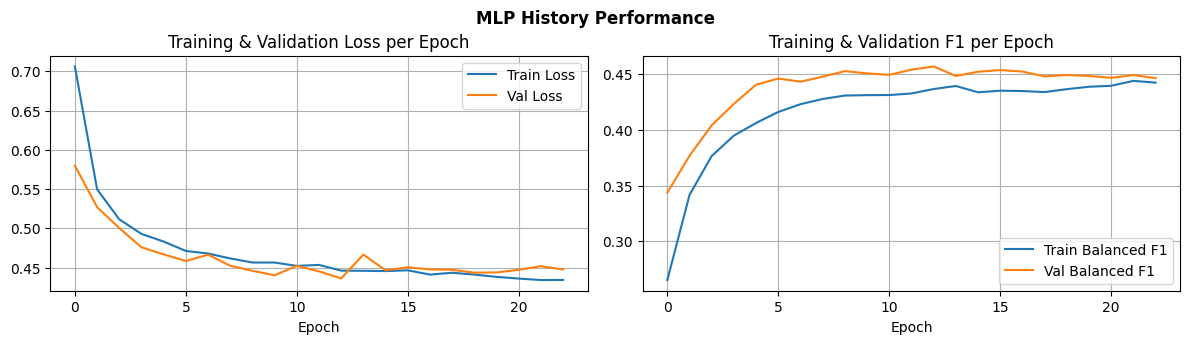

In [91]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal", input_shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(1, activation="sigmoid")
])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_f1', mode='max',
                                                     patience=10, restore_best_weights=True) 

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[balanced_f1])

history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_val_scaled, y_val),
                    batch_size=128, sample_weight=sample_weights,
                    callbacks=[early_stopping_cb, lr_scheduler])

plot_history(history, 'MLP History Performance')

In [80]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)
print(classification_report(y_test, dnn_y_test_pred.round()))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     10463
           1       0.31      0.83      0.45      1333

    accuracy                           0.77     11796
   macro avg       0.64      0.80      0.66     11796
weighted avg       0.90      0.77      0.81     11796

79.70% - Balanced accuracy Test
80.81% - Balanced accuracy Train


369/369 [==============================] - 1s 1ms/step


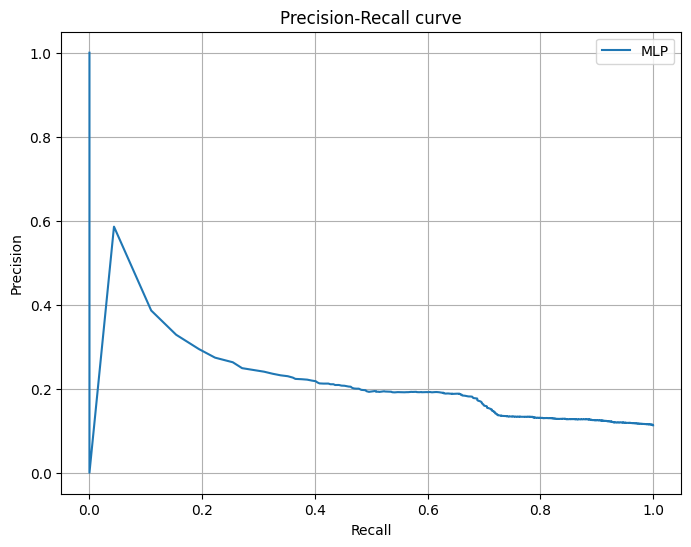

In [81]:
from sklearn.metrics import precision_recall_curve

y_scores = model.predict(X_test)

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

[[8035 2428]
 [ 232 1101]]


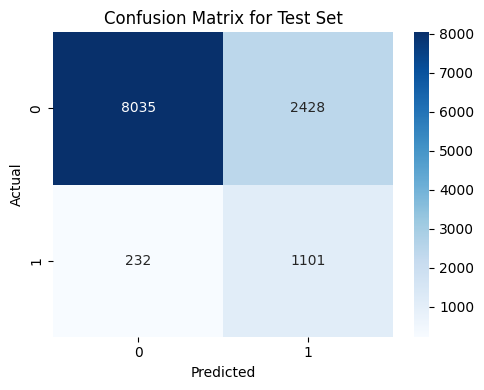

In [82]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
print(test_cm)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

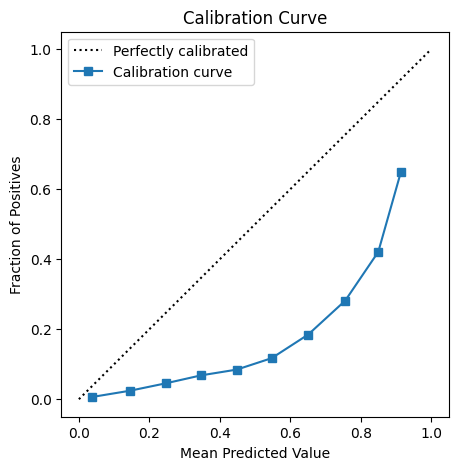

In [83]:
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

### Max Learning Rate Identification

Epoch 1/2
590/590 [==============================] - 4s 6ms/step - loss: 0.6678 - balanced_f1: 0.2536 - val_loss: 0.6044 - val_balanced_f1: 0.0000e+00
Epoch 2/2
590/590 [==============================] - 1s 2ms/step - loss: 3334886400.0000 - balanced_f1: 0.0969 - val_loss: 1281996160.0000 - val_balanced_f1: 0.0473


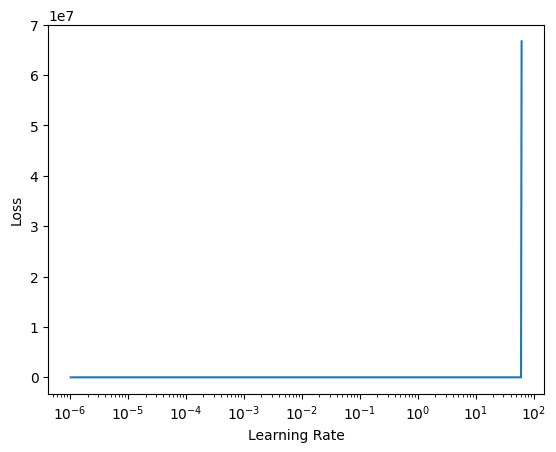

In [87]:
from tensorflow.keras.callbacks import Callback

tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Custom callback for Learning Rate Range Test
class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, steps, beta=0.98):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.beta = beta
        self.avg_loss = 0.
        self.best_loss = float('inf')
        self.batch_num = 0
        self.losses = []
        self.lrs = []
        self.steps = steps

    def on_batch_end(self, batch, logs=None):
        self.batch_num += 1
        lr = self.min_lr * (self.max_lr / self.min_lr) ** (self.batch_num / self.steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        
        # Compute the smoothed loss
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * logs['loss']
        smoothed_loss = self.avg_loss / (1 - self.beta ** self.batch_num)
        self.losses.append(smoothed_loss)
        self.lrs.append(lr)
        
        # Stop if the loss explodes
        if self.batch_num > 1 and smoothed_loss > 4 * self.best_loss:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.batch_num == 1:
            self.best_loss = smoothed_loss

# Assuming your model and data are ready
model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal", input_shape=X_train_scaled.shape[1:]),
    # tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal"),
    # tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal"),
    # tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=[balanced_f1])

# Define steps and range for learning rate
steps = np.ceil(len(X_train_scaled) / 64)  # Assuming batch size of 64
lr_finder = LRFinder(min_lr=1e-6, max_lr=1, steps=steps)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train model using the Learning Rate Finder
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_val_scaled, y_val),
          batch_size=64, sample_weight=sample_weights,
          callbacks=[lr_finder])

# Plot Loss vs Learning Rate
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

### Optuna

In [89]:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_param_importances
import sqlite3

In [102]:
# from optuna.integration import TFKerasPruningCallback
# kernel initialiser and activation function were found to have little hyperparam impact

tf.keras.backend.clear_session()
tf.random.set_seed(42)

def build_model(trial):
    n_hidden = trial.suggest_int("n_hidden", 2, 12)
    n_neurons = trial.suggest_int("n_neurons", 10, 80)
    dropout = trial.suggest_float("dropout", 0, 0.5, step=0.1)  # try no dropout 
    activation = trial.suggest_categorical("activation", ['relu', 'swish'])
    kernel_initializer = trial.suggest_categorical('kern_init', ['he_normal', 'glorot_uniform'])
    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    
    optimizer_choice = trial.suggest_categorical('optimizer', ['sgd', 'momentum', 'adam'])
    
    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'momentum':
        momentum = trial.suggest_float('momentum', 0.1, 0.9)
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    elif optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(X_train_scaled.shape[1:]))
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
        model.add(tf.keras.layers.Dropout(dropout))
        
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=[balanced_f1])
    return model

def objective(trial):
    model = build_model(trial)
    
    factor = trial.suggest_float("factor", 0.1, 0.9, step=0.1)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=factor, patience=5)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_f1', mode='max',
                                                         patience=10, restore_best_weights=True)
    
    pruning_callback = TFKerasPruningCallback(trial, 'val_balanced_f1')
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    
    history = model.fit(X_train_scaled, y_train, epochs=100,
                        batch_size=128, validation_data=(X_val_scaled, y_val),
                        callbacks=[early_stopping_cb, lr_scheduler, pruning_callback],
                        verbose=0,
                        sample_weight=sample_weights)
    
    return max(history.history["val_balanced_f1"])

study = optuna.create_study(
    study_name='optuna_mlp',
    storage='sqlite:///optuna_mlp.db',
    load_if_exists=True, 
    direction='maximize', pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=50, timeout=1800)

[I 2023-10-06 07:19:10,322] Using an existing study with name 'optuna_mlp' instead of creating a new one.
[I 2023-10-06 07:19:52,199] Trial 12 finished with value: 0.46650230884552 and parameters: {'n_hidden': 6, 'n_neurons': 27, 'dropout': 0.2, 'activation': 'relu', 'kern_init': 'he_normal', 'lr': 0.023584790307267067, 'optimizer': 'adam', 'factor': 0.30000000000000004}. Best is trial 7 with value: 0.46692150831222534.
[I 2023-10-06 07:19:56,179] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2023-10-06 07:20:00,674] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2023-10-06 07:20:21,146] Trial 15 pruned. Trial was pruned at epoch 12.
[I 2023-10-06 07:20:48,033] Trial 16 finished with value: 0.45364561676979065 and parameters: {'n_hidden': 5, 'n_neurons': 10, 'dropout': 0.30000000000000004, 'activation': 'relu', 'kern_init': 'he_normal', 'lr': 0.03288190921458509, 'optimizer': 'adam', 'factor': 0.2}. Best is trial 7 with value: 0.46692150831222534.
[I 2023-10-06 07:20:53,933] Trial

KeyboardInterrupt: 

In [103]:
study = optuna.load_study(study_name='optuna_mlp', storage='sqlite:///optuna_mlp.db')

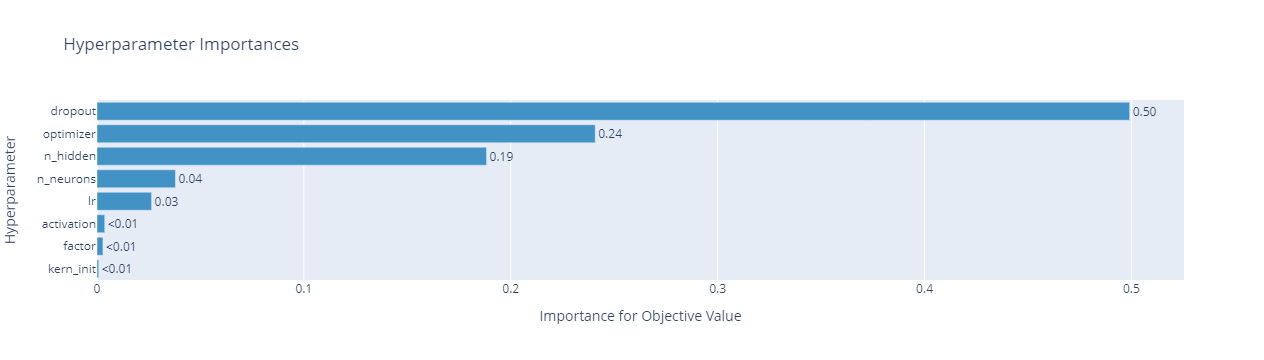

In [104]:
# eval hyperparameter importances 14:34 of video
optuna.importance.get_param_importances(study)

# Plot the parameter importances
plot_param_importances(study)

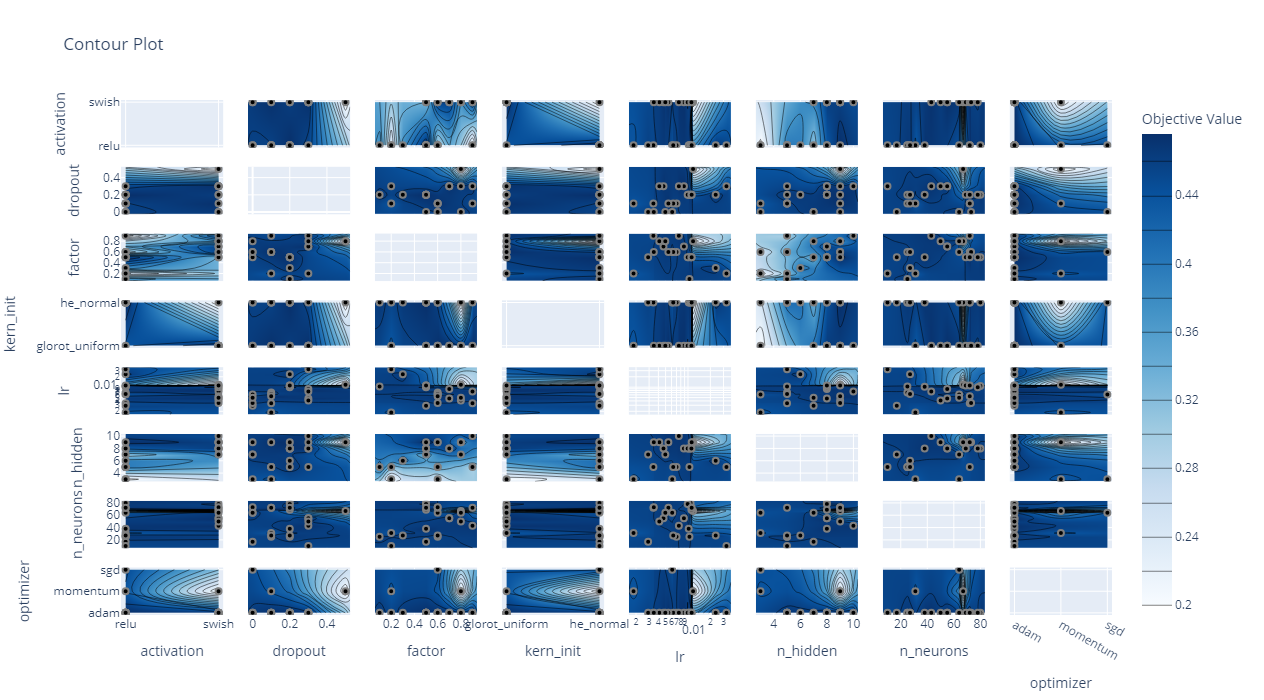

In [105]:
fig = optuna.visualization.plot_contour(study, 
                                        params=[
                                            'optimizer', 'n_hidden', 
                                            'dropout', 'n_neurons', 'factor',
                                            'kern_init', 'activation', 'lr'])

fig.update_layout(height=700)
fig.show()

/tmp/ipykernel_44/1242790794.py:6: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



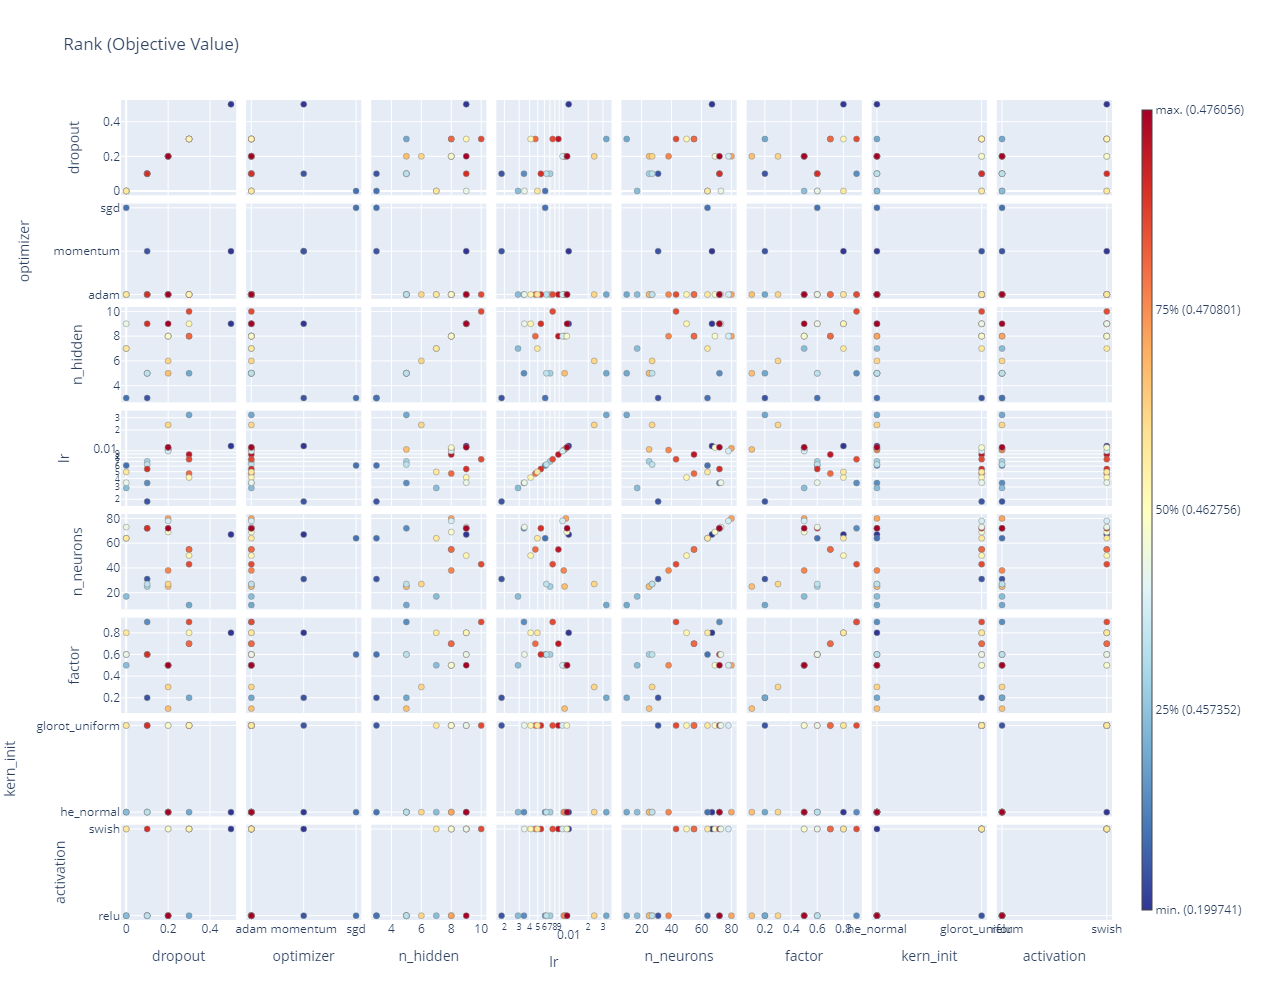

In [106]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted)
fig.update_layout(height=1000)
fig.show()

/tmp/ipykernel_44/2903521836.py:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



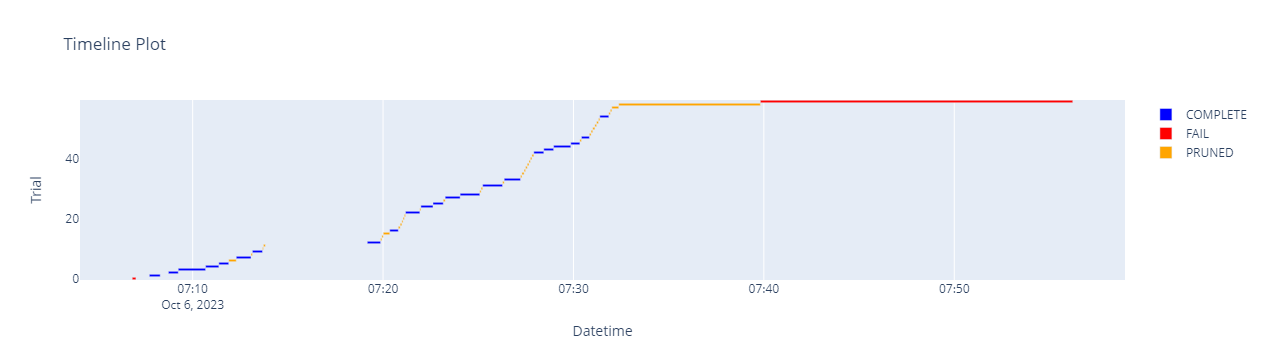

In [107]:
fig = optuna.visualization.plot_timeline(study)
fig.show()

In [108]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  60
Best trial:
  Value:  0.4760556221008301
  Params: 
    n_hidden: 9
    n_neurons: 72
    dropout: 0.2
    activation: relu
    kern_init: he_normal
    lr: 0.011202660824293517
    optimizer: adam
    factor: 0.5


In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Define the balanced accuracy metric
def balanced_accuracy(y_true, y_pred):
    y_pred_labels = K.round(y_pred)
    recall_pos = K.sum(K.round(K.clip(y_true * y_pred_labels, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    recall_neg = K.sum(K.round(K.clip((1-y_true) * (1-y_pred_labels), 0, 1))) / (K.sum(K.round(K.clip(1-y_true, 0, 1))) + K.epsilon())
    balanced_acc = (recall_pos + recall_neg) / 2.0
    return balanced_acc

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=5, step=1, default=3)  # 4 possible options
    n_neurons = hp.Int("n_neurons", min_value=5, max_value=75, step=10, default=15)  # 8 possible options
    dropout = hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1) # 5 hyperparams
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_neurons, activation="swish", kernel_initializer="he_normal", input_shape=X_train_scaled.shape[1:]))
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='swish', kernel_initializer="he_normal"))
        model.add(tf.keras.layers.Dropout(dropout))  # Dropout layer 
        
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))  # output layer

    
    model.compile(loss="binary_crossentropy",
                  optimizer=Adam(learning_rate=0.001),
                  metrics=[balanced_accuracy])
    return model

In [18]:
for i in range(0, 3):
    print(f'Model {i+1}')
    random_search_tuner.oracle.get_best_trials(num_trials=3)[i].summary()
    print('\n')

Model 1
Trial 031 summary
Hyperparameters:
n_hidden: 3
n_neurons: 45
dropout: 0.4
Score: 0.804882824420929


Model 2
Trial 081 summary
Hyperparameters:
n_hidden: 4
n_neurons: 75
dropout: 0.4
Score: 0.8001174330711365


Model 3
Trial 125 summary
Hyperparameters:
n_hidden: 2
n_neurons: 35
dropout: 0.5
Score: 0.7982808947563171




In [46]:
# get the best model and fit its history
best_model = random_search_tuner.get_best_models(num_models=1)[0]

Epoch 1/100
100/100 [==============================] - 1s 7ms/step - loss: 0.4732 - balanced_accuracy: 0.7826 - val_loss: 0.4427 - val_balanced_accuracy: 0.8023 - lr: 2.5000e-04
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4583 - balanced_accuracy: 0.7892 - val_loss: 0.4410 - val_balanced_accuracy: 0.8020 - lr: 2.5000e-04
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.4688 - balanced_accuracy: 0.7894 - val_loss: 0.4432 - val_balanced_accuracy: 0.8011 - lr: 2.5000e-04
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4548 - balanced_accuracy: 0.7929 - val_loss: 0.4434 - val_balanced_accuracy: 0.8007 - lr: 2.5000e-04
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4510 - balanced_accuracy: 0.7947 - val_loss: 0.4430 - val_balanced_accuracy: 0.7998 - lr: 2.5000e-04
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.4555 - balanced_accuracy: 0.7901 

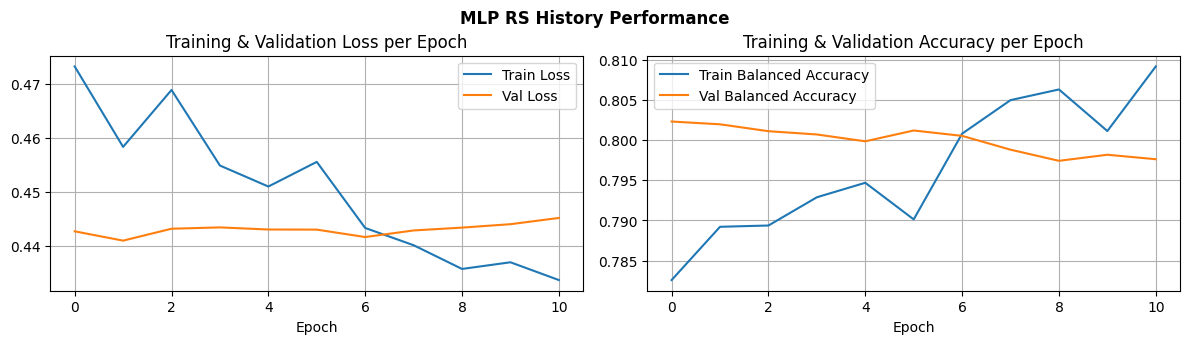

In [48]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy', mode='max',
                                                     patience=10, restore_best_weights=True)

history = best_model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_val_scaled, y_val),
                    batch_size=64, sample_weight=sample_weights,
                    callbacks=[early_stopping_cb, lr_scheduler])

plot_history(history, 'MLP RS History Performance')

In [53]:
# train and test predictions
dnn_y_test_pred = best_model.predict(X_test_scaled)
dnn_y_train_pred = best_model.predict(X_train_scaled)
print(classification_report(y_test, dnn_y_test_pred.round()))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

200/200 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       870
           1       0.78      0.83      0.80      1130

    accuracy                           0.77      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.77      0.77      0.77      2000

76.47% - Balanced accuracy Test
80.51% - Balanced accuracy Train


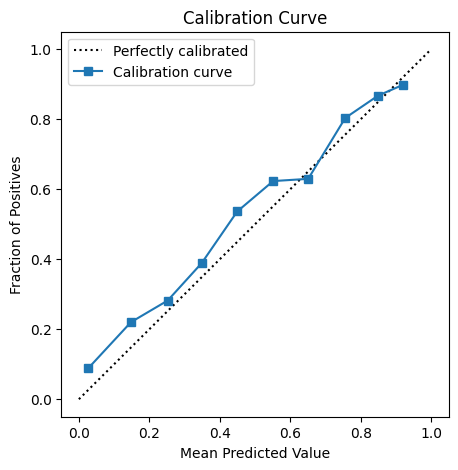

In [40]:
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [61]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

63/63 [==============================] - 0s 2ms/step


Epoch 1/100
100/100 [==============================] - 2s 8ms/step - loss: 0.7270 - balanced_accuracy: 0.5793 - val_loss: 0.5603 - val_balanced_accuracy: 0.7286 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.5993 - balanced_accuracy: 0.6856 - val_loss: 0.5052 - val_balanced_accuracy: 0.7595 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.5421 - balanced_accuracy: 0.7339 - val_loss: 0.4693 - val_balanced_accuracy: 0.7714 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.5092 - balanced_accuracy: 0.7615 - val_loss: 0.4613 - val_balanced_accuracy: 0.7724 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4868 - balanced_accuracy: 0.7773 - val_loss: 0.4575 - val_balanced_accuracy: 0.7755 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4694 - balanced_accuracy: 0.7875 - val_loss: 0.4511 -

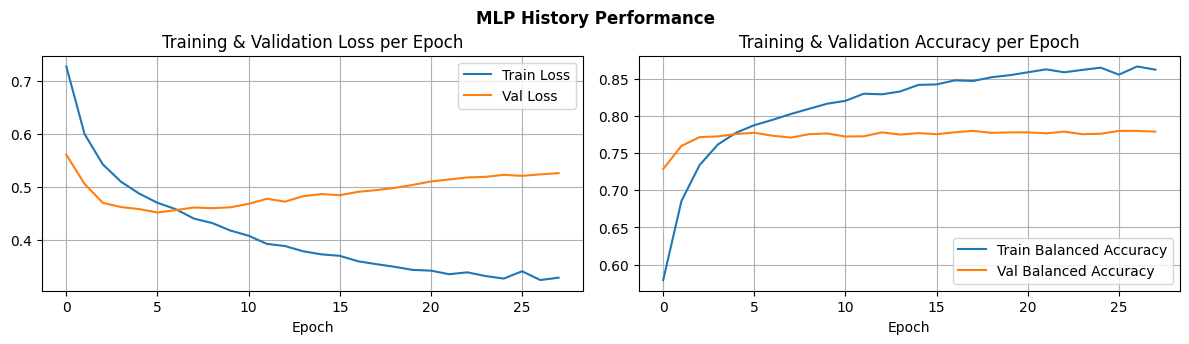

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization(input_shape=X_train_scaled.shape[1:])
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(45, activation="swish", kernel_initializer="he_normal", input_shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Dense(45, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(45, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(45, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(1, activation="sigmoid")
])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy', mode='max',
                                                     patience=10, restore_best_weights=True) 

model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=[balanced_accuracy])

history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_val_scaled, y_val),
                    batch_size=64, sample_weight=sample_weights,
                    callbacks=[early_stopping_cb, lr_scheduler])

plot_history(history, 'MLP History Performance')

63/63 [==============================] - 0s 2ms/step


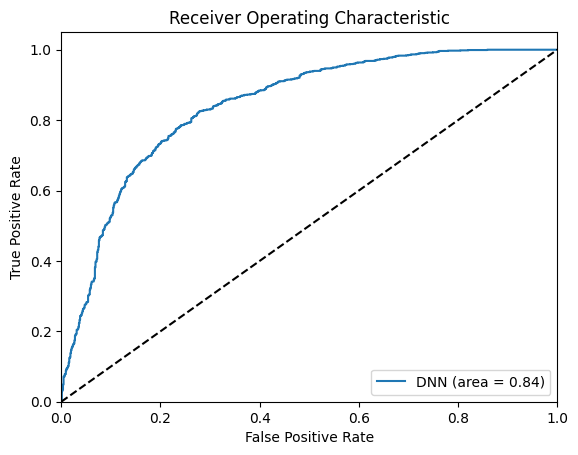

In [64]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_sm) 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal", input_shape=X_train_scaled.shape[1:]),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(40, activation="swish", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.4),  # Dropout layer added here
    tf.keras.layers.Dense(1, activation="sigmoid")
])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy', mode='max',
                                                     patience=10, restore_best_weights=True) 

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[balanced_accuracy])

history = model.fit(X_train_scaled, y_train_sm, epochs=100,
                    validation_data=(X_val_scaled, y_val),
                    batch_size=64,
                    callbacks=[early_stopping_cb, lr_scheduler])

plot_history(history, 'MLP History Performance')

### DNN (Shiv)

In [ ]:
dims = 500

X_train_scaled_new = X_train_scaled[:,:dims]
X_val_new = X_val[:,:dims]
X_test_scaled_new = X_test_scaled[:,:dims]

import tensorflow as tf

In [ ]:
inp = Input(shape=[dims,])
out = inp

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


for ix in range(3):
  out = Dense(64,activation='swish')(out)
  out = Dropout(0.2)(out)
out_encoder = Dense(64)(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model_encoder = Model(inp,out_encoder)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled_new, y_train, epochs=100, batch_size=64, validation_data=(X_val_new, y_val),sample_weight=sample_weights,
                   callbacks=[early_stopping, lr_scheduler])

In [ ]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled_new)
dnn_y_train_pred = model.predict(X_train_scaled_new)
print(classification_report(y_test, dnn_y_test_pred.round()))

In [ ]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

#### UMAP and Agglomerative clustering

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [ ]:
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install bokeh holoviews colorcet scikit-image datashader

In [ ]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled_new).numpy()
Xenc_test = model_encoder(X_test_scaled_new)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled_new).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

In [ ]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

# # Scatter Plot for 2D UMAP Visualization
# x_coords = embedding[:, 0]
# y_coords = embedding[:, 1]
# plt.scatter(x_coords, y_coords, c=labels, cmap='jet', s=15, alpha=0.6, edgecolors='w')
# plt.xlabel('UMAP 1st component')
# plt.ylabel('UMAP 2nd component')
# plt.colorbar(label='Label')
# plt.title('2D UMAP Visualization with Labels')
# plt.show()

#### SHAP Analysis

In [ ]:
# SHAP analysis
import shap

# Convert pandas DataFrame to numpy array if needed
X_train_scaled_new_array = np.array(X_train_scaled_new)
X_test_scaled_new_array = np.array(X_test_scaled_new)

# Use a smaller random sample for background
background_sample = X_train_scaled_new_array[np.random.choice(X_train_scaled_new_array.shape[0], 1000, replace=False)]

# Initialize the explainer object
explainer = shap.DeepExplainer(model, background_sample)

# Compute the SHAP values
shap_values = explainer.shap_values(X_test_scaled_new_array)

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled_new_array)



## Deep Neural Network (DNN)

In [ ]:
# Adjust class weight
# class_weight_0 = len(y_train) / (2 * np.sum(y_train == 0))
# class_weight_1 = len(y_train) / (2 * np.sum(y_train == 1))
# class_weights = {0: class_weight_0, 1: class_weight_1}

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

In [ ]:
model.summary()

Plot Learning Curves

In [ ]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [ ]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

In [ ]:
print(classification_report(y_test, dnn_y_test_pred.round()))

In [ ]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [ ]:
# calibration curve

prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated"). This would mean that for items where the model predicts, say, a 70% chance, 70% of those items actually belong to the positive class.

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

In [ ]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

In [ ]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, rf_y_pred.round())
train_cm = confusion_matrix(y_train, rf_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [ ]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

In [ ]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [ ]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

In [ ]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, xgb_predictions.round())
train_cm = confusion_matrix(y_train, xgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('XGBoost Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LightGBM

In [ ]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_train_predictions = lgb_model.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

In [ ]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, lgb_predictions.round())
train_cm = confusion_matrix(y_train, lgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Light GBM Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


In [ ]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

In [ ]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, logistic_predictions.round())
train_cm = confusion_matrix(y_train, logistic_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Logistic Regression Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

In [ ]:
!pip install shap

In [ ]:
import shap

# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values = explainer(X_test_scaled)

# force plot for the first instance
# shap.initjs()
# shap.plots.force(shap_values[0])

# Summary plot to show feature importance for the entire dataset
shap.summary_plot(shap_values, X_test_scaled)

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output

## ROC Curve for all models

In [ ]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
